In [23]:
from numba import cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32
import numpy as np
import numba
import math
"""
Kernels Numba para batch SOM
Necesitamos:
a) Calcular las distancias euclídas entre un
   conjunto de muestras y los pesos de las neuronas.
b) Encontrar el índice de los pesos de neuronas con distancia mínima.
c) Actualizar los pesos de las neuronas conforme a la ecuación correspondiente.
"""

"""
A) Cálculo de distancia euclídea.
Puesto que lo usamos para la relación de orden podemos obviar el cálculo de la raíz cuadrada.

Uso de memoria compartida y bloques
------------------------------------
Mantenemos los pesos de la neurona del bloque en memoria compartida y 
calculamos la distancia de la neurona con el conjunto de muestras.

Si
N= Nº de muestras
nneurons = filas * columnas = Nº neuronas
d = dimensión del problema
tpb = Thhreads per Block

necesitamos lanzar un grid de (nneurons, N // tpb + 1) bloques de tpb hebras
"""

@cuda.jit
def euclidean_distance(samples, weights, distances, nneurons, d):
    """
    Kernel para calcular la distancia euclídea de todas las muestras
    con los pesos
    :param samples Conjunto de todas las muestras a evaluar.
    :param weights Array de filas * columnas * d valores con los pesos 
    asociados a cada una de las neuronas.
    :param distances Array de tamaño N * nneurons para almacenar
    las distancias
    :param nneurons Número de neuronas totales en el mapa.
    :param d Dimensión de cada muestra.
    """
    # 1. Tomamos los índices que nos correspoden
    neuron_idx = cuda.blockIdx.x
    samples_idx = cuda.blockIdx.y * cuda.blockDim.x + cuda.threadIdx.x
    
    
    # 2. Ponemos los pesos de la neurona en memoria compartida
    shared_weights = cuda.shared.array(shape=0, dtype=numba.float32)
    for i in range(d // cuda.blockDim.x + 1):
        i_stride = i * cuda.blockDim.x
        my_pos = i_stride + cuda.threadIdx.x
        if my_pos < d:
            shared_weights[my_pos] = weights[neuron_idx * d + my_pos]
            
    cuda.syncthreads()
    
    # 3. Procedemos a realizar el cálculo de la distancia si procede
    if neuron_idx < nneurons:
        distance = 0.0
        for i in range(d):
            i_distance = samples[samples_idx * d + i] - shared_weights[i]
            distance += i_distance * i_distance
            
        distances[samples_idx * nneurons + neuron_idx] = distance

In [24]:
"""
b) Encontrar el menor índice da las distancias.

Este proceso se realiza mediante una reducción.
En la reducción planteada trabajamos con los datos y los índices asociados.

Esta versión tiene hecho unroll tanto para el bloque como para el warp
y está hecho el unroll para trabajar con 128 hebras por bloque, se puede ampliar
con facilidad si nos interesase más hebras por bloque.

Si hay más de un bloque se vuelve a lanzar el kernel, hasta que sólo quede uno.
En caso de haber varios mínimos el primero que sea procesado (no tiene por qué
ser el primero en orden secuencial del array) es el que se devuelve.

La implementación se corresponde a
https://developer.download.nvidia.com/assets/cuda/files/reduction.pdf
pero adaptada a encontrar el mínimo en vez de la suma.
"""

@cuda.jit
def cuda_min_element(my_array, my_mins, my_indexes):
    # 1. Declaramos la memoria compartida
    shared_mem = cuda.shared.array(shape=128, dtype=numba.float32)
    shared_idx = cuda.shared.array(shape=128, dtype=numba.int32)
    
    # 2. Obtenemos los índices
    tidx = cuda.threadIdx.x
    idx = cuda.blockDim.x  * cuda.blockIdx.x + tidx
    
    # 3. Inicialiamos a infinito
    shared_mem[tidx] = np.inf
    
    # 4. Cada thread comprueba un stride del grid
    while idx < my_array.size:
        if my_array[idx] < shared_mem[tidx]:
            shared_mem[tidx] = my_array[idx]
            shared_idx[tidx] = idx
                      
        idx += cuda.blockDim.x * cuda.gridDim.x
    cuda.syncthreads()
    
    idx = cuda.blockDim.x * cuda.blockIdx.x + tidx
        
    # 5. Unroll de bloque
    # Consideramos que estamos usando 128 hebras por bloque.
    if tidx < 64:
        if shared_mem[tidx + 64] < shared_mem[tidx]:
            shared_mem[tidx] = shared_mem[tidx + 64]
            shared_idx[tidx] = shared_idx[tidx + 64]
    
    cuda.syncthreads()
    
    
    # 6. Hacemos unroll para un warp (nos ahorramos syncthreads)
    if tidx < 32:
        if shared_mem[tidx + 32] < shared_mem[tidx]:
            shared_mem[tidx] = shared_mem[tidx + 32]
            shared_idx[tidx] = shared_idx[tidx + 32]
        if shared_mem[tidx + 16] < shared_mem[tidx]:
            shared_mem[tidx] = shared_mem[tidx + 16]
            shared_idx[tidx] = shared_idx[tidx + 16]
        if shared_mem[tidx + 8] < shared_mem[tidx]:
            shared_mem[tidx] = shared_mem[tidx + 8]
            shared_idx[tidx] = shared_idx[tidx + 8]
        if shared_mem[tidx + 4] < shared_mem[tidx]:
            shared_mem[tidx] = shared_mem[tidx + 4]
            shared_idx[tidx] = shared_idx[tidx + 4]
        if shared_mem[tidx + 2] < shared_mem[tidx]:
            shared_mem[tidx] = shared_mem[tidx + 2]
            shared_idx[tidx] = shared_idx[tidx + 2]
        if shared_mem[tidx + 1] < shared_mem[tidx]:
            shared_mem[tidx] = shared_mem[tidx + 1]
            shared_idx[tidx] = shared_idx[tidx + 1]
            
            
    # El primer thread de cada bloque indica su minimo
    # Si da para más de un bloque, luego hay que reaplicar el kernel
    if tidx == 0:
        my_mins[cuda.blockIdx.x] = shared_mem[tidx]
        my_indexes[cuda.blockIdx.x] = shared_idx[tidx]


def reduce_min_index(a):
    list_indexes = []
       
    def set_kernel_params(a):
        threads = min(a.size, 128)
        blocks = a.size // threads
        sm_size = threads * 2 * 4
        mins = np.empty(blocks, np.float32)
        indexes = np.empty(blocks, np.int32)
        return blocks, threads, 0, sm_size, a, mins, indexes
        
    def run_kernel(p):
        cuda_min_element[p[0], p[1]](p[4], p[5], p[6])
        
    p = set_kernel_params(a)
    if p[0] == 1:
        run_kernel(p)
        return p[6][0]
    else:
        while p[0] > 1:
            run_kernel(p)
            list_indexes.append(p[6])
            a = p[5]
            p = set_kernel_params(a)
        run_kernel(p)
        list_indexes.append(p[6])
        
        output_index = 0
        for indexes in list_indexes[::-1]:
            output_index = indexes[output_index]
            
        return output_index
  


In [25]:
"""
C) Actualización de los pesos de las neuronas.
La fórmula se corresponde a un cociente de sumatorias.
Para resolverlo, en el kernel prepare_update se realizan
los cálculos del numerador y del denominador por separado.

Uso de memoria compartida y bloques
------------------------------------
En este caso, usamos la memoria compartida para asegurarnos de que
la muestra está en caché y no tenga que ser cargada de nuevo mientras
se evalúan todas las neuronas.

necesitamos lanzar un grid de (N, nneurons // tpb + 1) bloques de tpb hebras
"""

@cuda.jit
def prepare_update(bmu, samples, num, den, 
    nrows, ncols, d, sigma_squared):
    """
    Este kernel calcula numerador y denominador de la fórmula para
    la actualización de pesos iterativos del batch mediante
    sumas atómicas.
    :param bmu Vector con las posiciones de la BMU.
    :param samples Conjunto de las muestras usadas para entrenar.
    :param num Vector con los numeradores para el cálculo de la fórmula.
    :param den Vector con los denominadores para el cálculo de la fórmula.
    :param nrows Número de filas en la capa de salida.
    :param ncols Número de columnas en la capa de salida.
    :param d Dimensión de cada muestra.
    :param sigma_squared Valor de sigma al cuadrado para el
    cáculo del vecindario.
    """
    # 1. Tomamos los índices que correspondan
    sample_idx = cuda.blockIdx.x
    neuron_idx = cuda.blockIdx.y * cuda.blockDim.x + cuda.threadIdx.x
   
    # 2. Metemos en memoria compartida la muestra que se lee en todo el bloque
    shared_sample = cuda.shared.array(shape=0, dtype=numba.float32)
    for i in range(d // cuda.blockDim.x + 1):
        i_stride = i * cuda.blockDim.x
        my_pos = i_stride + cuda.threadIdx.x
        if my_pos < d:
            shared_sample[my_pos] = samples[sample_idx * d + my_pos]
    cuda.syncthreads()
    
    # 3. Si procede realizar cálculos los hacemos
    if neuron_idx < nrows * ncols:
        bmu_row = bmu[sample_idx] // ncols
        bmu_col = bmu[sample_idx] % ncols
        neuron_row = neuron_idx // ncols
        neuron_col = neuron_idx % ncols
        
        dist = (neuron_row - bmu_row) * (neuron_row - bmu_row) + (neuron_col - bmu_col) * (neuron_col - bmu_col)
        
        if dist <= sigma_squared:
            hck = math.exp(-dist/(2 * sigma_squared))
            # Guardamos sumatoria del denominador
            cuda.atomic.add(den, neuron_row * ncols + neuron_col, hck)
            # Guardamos sumatoria del numerador
            for i in range(d):
                cuda.atomic.add(num, neuron_row * ncols * d + neuron_col * d + i, hck * shared_sample[i])


In [26]:
"""
Entrenar un modelo usando Spark y Numba CUDA
"""
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local").appName("SOFM").config("spark.executor.memory", "4gb").getOrCreate()
sc = spark.sparkContext


In [27]:
def gpu_work_iter(d, rows, cols, weights, sigma_squared, tpb=128):
    # Declarada función interna para devolverla y poder utilizar
    # múltiples parámetros al llamar a mapPartitions
    def _gpu_work(data):
        # 1. Procesamos el dataset
        inp = np.asarray(list(data), dtype=np.float32)
        N = inp.size // d
        nneurons = rows * cols
        dsamples = inp.flatten()
        # 2. Generamos un estructura en el dispositivo para almacenar las distancias
        distances = cuda.device_array(N * nneurons)
       
        # 3. Calcuamos las distancias
        sm_size = 4 * d
        euclidean_distance[(nneurons, N // tpb + 1),tpb, 0, sm_size](dsamples, weights, distances, nneurons, d)
        
        # 4. Realizamos las reducciones para todas las muestras
        bmu = np.array([reduce_min_index(distances[nneurons*i:nneurons*(i+1)]) for i in range(N)])
        
        # 5. Calculamos el numerador y denominador parcial asociado
        num = np.zeros(rows * cols * d, np.float32)
        den = np.zeros(rows * cols, np.float32)
        
        dnum = cuda.to_device(num)
        dden = cuda.to_device(den)
        prepare_update[(N, (rows * cols) // tpb + 1), tpb,0, sm_size](bmu, dsamples, dnum, dden, rows, cols, d, sigma_squared)
        
        return dnum.copy_to_host(), dden.copy_to_host()
    return _gpu_work

In [28]:
@cuda.jit
def finish_update(weights, partials, numParts, nrows, ncols, d):
    """
    Este kernel terminas las sumas parciales.
    Se ejecuta en un único nodo de Spark.
    
    :param weights Array de pesos de neuronas
    :param partials Array con sumas parciales
    :param numParts Número de resultados parciales a procesar.
    :param nrows Número de filas en la capa de salida.
    :param ncols Número de columnas en la capa de salida.
    :param d Dimensión de cada muestra.
    
    Estrucutra de bloques
    ---------------------
    Lanzamos nrows * ncols // tpb + 1 bloques.
    """
    idx = cuda.grid(1)
    if idx < nrows * ncols:
        row = idx // ncols
        col = idx % ncols
        
        
        # a) Sumamos todos los parciales en el primer array
        numsize = nrows * ncols * d
        densize = nrows * ncols
        fullsize = numsize + densize
        for i in range(numParts - 1):
            # Suma de numeradores
            for k in range(d):
                partials[row * ncols * d + col * d + k] += partials[fullsize * i + row * ncols * d + col * d + k]
            # Suma de denominadores
            partials[numsize + row * ncols + col] += partials[fullsize * i + numsize + row * ncols + col]
            
    cuda.syncthreads()
    
    if idx < nrows * ncols:
        # b) Si no es 0 el denominador realizamos la división y cambiamos pesos actuales
        if partials[numsize + row * ncols + col] != 0:
            for k in range(d):
                weights[row * ncols * d + col * d + k] =  partials[row*ncols*d + col*d +k] / \
                    partials[numsize + row * ncols + col]
      
"""
Kernel para inicializar aleatoriamente la 'matriz' de pesos con valores 
en el intervalo [0, 1) tomados de una distribución aleatoria
:param rng_states Estados aleatorios
:param weigths Vector de M * N * d valores que contendrá los pesos asociados a las neuronas
"""
@cuda.jit
def cuda_init_weights(rng_states, weights):
    idx = cuda.grid(1)
    if idx < weights.size:
        weights[idx] = xoroshiro128p_uniform_float32(rng_states, idx)


In [29]:
def spark_based_batch_som(sc, dataset, max_iters, rows, cols, smooth_iters=None, sigma_0=10, 
                          sigma_f=0.1, tau=400, seed=None, tpb=128):
    
    N, d = dataset.shape
    # 1. Inicializamos pesos aleatorios
    blocks = rows * cols * d // tpb + 1
    d_weights = cuda.device_array(rows * cols * d, np.float32)
    
    rng_states = create_xoroshiro128p_states(rows * cols * d, seed=seed)
    cuda_init_weights[rows * cols * d // tpb + 1, tpb](rng_states, d_weights)
    
    weights = d_weights.copy_to_host()
    
    # 2. Generamos un rdd con las muestras del dataset
    rdd_data = sc.parallelize(dataset)
    
    # 3. Bucle del algoritmo
    for t in range(max_iters):
        # 3.a Actualizamos los parámetros de control si procede
        if smooth_iters is None or t < max_iters:
            sigma = sigma_0 * math.exp((-t/tau))
        else:
            sigma = sigma_f
            
        sigma_squared = sigma * sigma
        
        # 3.b Cada nodo del clúster de spark trabajará con un subconjunto
        # de las muestras del RDD para encontrar la BMU y realizar la suma
        # parcial de su ecucación de actualización de pesos
        out = rdd_data.mapPartitions(gpu_work_iter(d, rows, cols, weights, sigma_squared))
        
        # 3.c En un único nodo usamos la GPU para juntar todas las sumas parciales obtenidas
        #   y realizar la división
        out = out.collect()
        numParts = len(out) // 2

        partials = np.concatenate(out)
        finish_update[rows * cols // tpb + 1, tpb](weights, partials, numParts, rows, cols, d)
       
    return weights

In [30]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
    
faces = fetch_olivetti_faces()['data']
rows = 20
cols = 20
d=faces.shape[1]
incio = time.time()
weights = spark_based_batch_som(sc, faces, 50, rows, cols, seed=30)
fin = time.time()


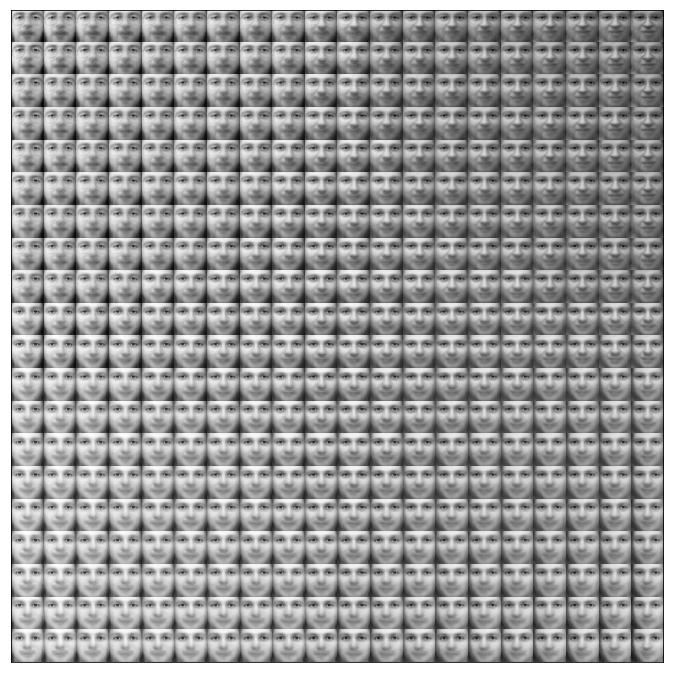

In [31]:
W = weights.reshape((rows, cols, d))
pattern_length = faces.shape[1]
pattern_width = pattern_height = int(np.sqrt(pattern_length))
matrix_side = 20
matrix_w = np.empty((matrix_side * pattern_height, matrix_side * pattern_width))
matrix_w *= 255


for i in range(matrix_side):
    for j in range(matrix_side):
        matrix_w[i * pattern_height:i * pattern_height + pattern_height, 
j * pattern_height:j * pattern_height + pattern_width] = W[i, j].reshape((pattern_height, pattern_width)) * 255.0
fig, ax = plt.subplots(figsize=(12,12))

ax.matshow(matrix_w.tolist(), cmap='gray')
ax.set_xticks([])
ax.set_yticks([])

plt.show()


In [32]:
def quantification_error(dataset, weights):
    error = 0.0
    for sample in dataset:
        error += np.min(np.linalg.norm(sample - weights,axis=2))

    return error / len(dataset)

quantification_error(faces, W)  

6.8542279911041257

In [33]:
def topography_error(dataset, weights):
    error = 0
    for sample in dataset:
        distances = np.linalg.norm(sample - weights, axis=2)

        bmus = np.argsort(distances, axis=None)[:2]
        bmu_rows = bmus // weights.shape[1]
        bmu_cols = bmus % weights.shape[1]

        if abs(bmu_rows[1] - bmu_rows[0]) == 1 and abs(bmu_cols[1] - bmu_cols[0]) == 1:
            error += 1

    return error / len(dataset)
topography_error(faces, W)

0.07

array([[[ 0.51022071,  0.5669927 ,  0.6429525 , ...,  0.18179467,
          0.18089584,  0.17450088],
        [ 0.51502806,  0.56878042,  0.64007163, ...,  0.17929082,
          0.17844981,  0.17332977],
        [ 0.5304777 ,  0.58122921,  0.64585131, ...,  0.18591426,
          0.18669002,  0.18429147],
        ..., 
        [ 0.41819912,  0.4392716 ,  0.46388975, ...,  0.37708864,
          0.38741782,  0.38356191],
        [ 0.39524776,  0.41634029,  0.44118893, ...,  0.39565989,
          0.40841261,  0.40223557],
        [ 0.34239247,  0.36072272,  0.38528186, ...,  0.42892092,
          0.44236058,  0.43262357]],

       [[ 0.50845748,  0.56419104,  0.63863701, ...,  0.18006757,
          0.17979269,  0.173362  ],
        [ 0.51514614,  0.56802088,  0.63769007, ...,  0.17972247,
          0.17942521,  0.17400923],
        [ 0.52883697,  0.5794158 ,  0.64311332, ...,  0.18696545,
          0.18697372,  0.18492374],
        ..., 
        [ 0.41906142,  0.44047683,  0.46461707, ...,